In [47]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from openai import OpenAI
import json
import os

In [48]:
def load_data(file_path):
    return pd.read_csv(file_path)


def filter_data(df, start_time, frame):
    def generate_range(start_time, frame):
        dtStart = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
        dtDiff = timedelta(hours=frame[0], minutes=frame[1])
        dest = dtStart + dtDiff
        return [start_time, dest.strftime('%Y-%m-%d %H:%M:%S')]
    
    time_range = generate_range(start_time, frame)
    return df[(df["time"] >= time_range[0]) & (df["time"] <= time_range[1])]

def initialize_api_client(api_key):
    return OpenAI(
        base_url="https://hackathon.radiantai.com/insight-ops/openai",
        api_key=api_key
    )


In [49]:


def process_post(post, api_client):
    
    system_prompt = """You are a helpful assistant designed to output JSON.
Your task is to extract information from social media posts or announcements relevant to the Ukraine Russian war and convert it into a graph database.

Here is how the graph database works:
Every object has a title and it has a type, the title indicates the name of the subject: this can be an person or "actor", event, or even concept, just make up a classification that is very standard.
Two objects may be related in some way and this may and in this case, you will add them to the relationships list, try to find fitting relationships between related objects. For example, if you create a relationship between a person and an event you can use the relationship "participated in" or "attended". Or if you have a person and a concept you can use "knows" or "is familiar with". Or if you have two events you can use "happened before" or "happened after". Make up a relationship.
How you will enter it in to the graph database it as follows:
{
  "subjects": [
    [ENTITY_ID: INT, TITLE: STR, TYPE: STR],
    [ENTITY_ID: INT, TITLE: STR, TYPE: STR],
    ...
  ],
  "relationships": [
    [ENTITY_ID_1: INT, RELATIONSHIP: STR, ENTITY_ID_2: INT, PROPERTIES: DICT],
    [ENTITY_ID_1: INT, RELATIONSHIP: STR, ENTITY_ID_2: INT, PROPERTIES: DICT],
    ...
  ]
]
If you can't pair a relationship with a pair of nodes don't add it.
When you find a node or relationship you want to add try to create a generic PROPERTY for it that describes the entity you can also think of it as a label.
Only include things relevant to the Ukraine Russia conflict"""

    
    response = api_client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        response_format={"type": "json_object"},
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Here's the post: {post} \\n Make sure to output in a JSON with the top level keys 'subjects' and 'relationships'"}
        ]
    )
    return json.loads(response.choices[0].message.content)

def extract_graph_data(df, api_client):
    """
    Iterate over a DataFrame of posts, process each one, and accumulate the graph data.
    
    Args:
    df (pandas.DataFrame): DataFrame containing the posts to process.
    api_client (OpenAI.Client): The API client instance.
    
    Returns:
    dict: A dictionary containing accumulated nodes and edges from all posts.
    """
    system_prompt = "Your task is to extract information from social media posts and convert it into a graph database."
    all_data = {'subjects': [], 'relationships': []}  # Initialize structure to hold combined data from all posts
    
    for index, row in df.iterrows():
        
        post_data = process_post(row['translation'], api_client)
        
        for x in post_data['subjects']:
            x[0] = row['id'] + '_' + str(x[0])
            
        for x in post_data['relationships']:
            x[0] = row['id'] + '_' + str(x[0])
            x[2] = row['id'] + '_' + str(x[2])
            
        
        all_data['subjects'].extend(post_data['subjects'])
        all_data['relationships'].extend(post_data['relationships'])
    
    return all_data




In [ ]:
def interpret_image(image_url, post, subjects, relationships, api_client):
  response = api_client.chat.completions.create(
    model='gpt-4-vision-preview',
    response_format={"type": "json_object"},
    messages=[
      {'role': 'system', 'content': 'You are a helpful assistant designed to output JSON.'},
      {'role': 'user', "content": [{'type': 'text', 'text': "What's in this image?"},
                                    {'type': 'image_url','image_url': {'url': image_url}}]}
    ]
  )

In [50]:
structured_data

{'subjects': [[1, 'Oles Buzina', 'person'],
  [2, 'Vladimir Zhirinovsky', 'person'],
  [3, 'Vladimir Solovyov', 'person'],
  [4, 'Duel Talk Show', 'event'],
  [1, 'Russian intelligence and missile forces', 'actor'],
  [2, 'Ukrainian Nazis', 'actor'],
  [3, 'S-300 launcher', 'event'],
  [4, 'Radar', 'event'],
  [5, 'Personnel', 'actor'],
  [6, 'Reconnaissance and strike complex', 'actor'],
  [7, 'Enemy', 'actor'],
  [8, 'Belgorod border', 'event'],
  [9, 'Kharkov region', 'event'],
  [10, '40V6M radar tower', 'event'],
  [1, 'Russians in the Kharkiv region', 'actor'],
  [2, "152-mm self-propelled gun 2C19 'Msta-S'", 'weapon'],
  [3, 'boys from Volyn', 'actor'],
  [4,
   '14th separate mechanized brigade named after Prince Roman the Great',
   'entity'],
  [5, 'small drone', 'weapon'],
  [1, 'Biden', 'person'],
  [2, 'Platform X', 'concept'],
  [3, 'Easter Sunday', 'event'],
  [4, 'Petya the First', 'person'],
  [1, 'Ukraine', 'actor'],
  [2, 'EU', 'actor'],
  [3, 'The Telegraph', 'actor

In [51]:
api_key = os.environ["HACKATHON_API_KEY"]
df = load_data('data/russia_social_media.csv')


In [52]:
filtered_df = filter_data(df, "2024-03-31 18:00:00", [1, 30]).head(5)
api_client = initialize_api_client(api_key)

In [53]:
structured_data = extract_graph_data(filtered_df, api_client)
structured_data

{'subjects': [['0007ed21-eb78-597d-9558-9dfa4f75ed3e_1',
   'Oles Buzina',
   'person'],
  ['0007ed21-eb78-597d-9558-9dfa4f75ed3e_2', 'Vladimir Zhirinovsky', 'person'],
  ['0007ed21-eb78-597d-9558-9dfa4f75ed3e_3', 'Vladimir Solovyov', 'person'],
  ['0007ed21-eb78-597d-9558-9dfa4f75ed3e_4', 'Duel Talk Show', 'event'],
  ['0007ed21-eb78-597d-9558-9dfa4f75ed3e_5',
   'Socio-political Topics',
   'concept'],
  ['0124953a-08ac-53d7-963b-8eacbeb43150_1', 'Russians', 'actor'],
  ['0124953a-08ac-53d7-963b-8eacbeb43150_2', 'Kharkiv region', 'location'],
  ['0124953a-08ac-53d7-963b-8eacbeb43150_3',
   "152-mm self-propelled gun 2C19 'Msta-S'",
   'weapon'],
  ['0124953a-08ac-53d7-963b-8eacbeb43150_4', 'Volyn', 'location'],
  ['0124953a-08ac-53d7-963b-8eacbeb43150_5',
   '14th separate mechanized brigade',
   'unit'],
  ['0124953a-08ac-53d7-963b-8eacbeb43150_6',
   'Prince Roman the Great',
   'person'],
  ['0124953a-08ac-53d7-963b-8eacbeb43150_7', 'small drone', 'technology'],
  ['0124953a-08ac-

In [54]:
def create_graph(data):
    G = nx.DiGraph()
    for node in data['subjects']:
        node_id, name, node_type = node
        print(name)
        G.add_node(node_id, name = name, node_type = node_type)
        
    for edge in data['relationships']:
        source, relation, target, props = edge
        G.add_edge(source, target, relation=relation)
    return G

def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=5, edge_color='gray', width=2)
    node_labels = {node: G.nodes[node]['name'] for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
    edge_labels = {(u, v): data['relation'] for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title('Graph Visualization')
    plt.axis('off')
    plt.show()

In [55]:
G = create_graph(structured_data)

Oles Buzina
Vladimir Zhirinovsky
Vladimir Solovyov
Duel Talk Show
Socio-political Topics
Russians
Kharkiv region
152-mm self-propelled gun 2C19 'Msta-S'
Volyn
14th separate mechanized brigade
Prince Roman the Great
small drone
@mysiagin_chat
Ukraine
EU
The Telegraph
European Parliament
extreme right-wing parties
European countries


In [56]:
for node in G.nodes():
    print(node)
    print(G.nodes[node]['name'])

0007ed21-eb78-597d-9558-9dfa4f75ed3e_1
Oles Buzina
0007ed21-eb78-597d-9558-9dfa4f75ed3e_2
Vladimir Zhirinovsky
0007ed21-eb78-597d-9558-9dfa4f75ed3e_3
Vladimir Solovyov
0007ed21-eb78-597d-9558-9dfa4f75ed3e_4
Duel Talk Show
0007ed21-eb78-597d-9558-9dfa4f75ed3e_5
Socio-political Topics
0124953a-08ac-53d7-963b-8eacbeb43150_1
Russians
0124953a-08ac-53d7-963b-8eacbeb43150_2
Kharkiv region
0124953a-08ac-53d7-963b-8eacbeb43150_3
152-mm self-propelled gun 2C19 'Msta-S'
0124953a-08ac-53d7-963b-8eacbeb43150_4
Volyn
0124953a-08ac-53d7-963b-8eacbeb43150_5
14th separate mechanized brigade
0124953a-08ac-53d7-963b-8eacbeb43150_6
Prince Roman the Great
0124953a-08ac-53d7-963b-8eacbeb43150_7
small drone
0124953a-08ac-53d7-963b-8eacbeb43150_8
@mysiagin_chat
021268ea-9135-5761-9200-34ff70d93547_1
Ukraine
021268ea-9135-5761-9200-34ff70d93547_2
EU
021268ea-9135-5761-9200-34ff70d93547_3
The Telegraph
021268ea-9135-5761-9200-34ff70d93547_4
European Parliament
021268ea-9135-5761-9200-34ff70d93547_5
extreme rig

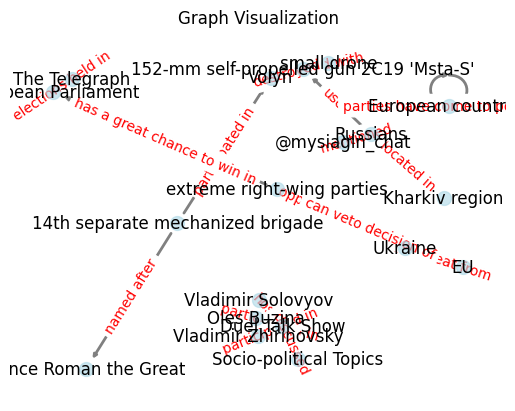

In [57]:
draw_graph(G)

In [58]:
nx.write_gml(G, 'test1.gml')

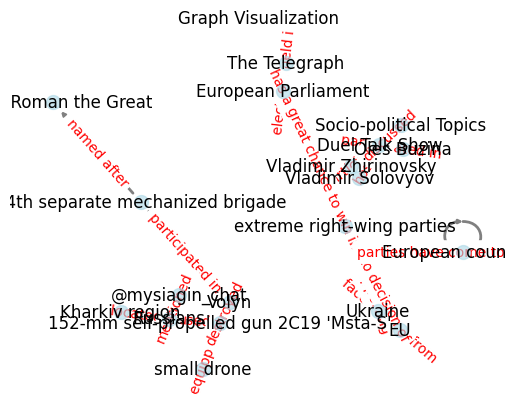

In [59]:
draw_graph(G)

In [60]:
# Display the graph
print("Nodes in the graph:")
print(G.nodes(data=True))

print("Edges in the graph:")
print(G.edges(data=True))

Nodes in the graph:
[('0007ed21-eb78-597d-9558-9dfa4f75ed3e_1', {'name': 'Oles Buzina', 'node_type': 'person'}), ('0007ed21-eb78-597d-9558-9dfa4f75ed3e_2', {'name': 'Vladimir Zhirinovsky', 'node_type': 'person'}), ('0007ed21-eb78-597d-9558-9dfa4f75ed3e_3', {'name': 'Vladimir Solovyov', 'node_type': 'person'}), ('0007ed21-eb78-597d-9558-9dfa4f75ed3e_4', {'name': 'Duel Talk Show', 'node_type': 'event'}), ('0007ed21-eb78-597d-9558-9dfa4f75ed3e_5', {'name': 'Socio-political Topics', 'node_type': 'concept'}), ('0124953a-08ac-53d7-963b-8eacbeb43150_1', {'name': 'Russians', 'node_type': 'actor'}), ('0124953a-08ac-53d7-963b-8eacbeb43150_2', {'name': 'Kharkiv region', 'node_type': 'location'}), ('0124953a-08ac-53d7-963b-8eacbeb43150_3', {'name': "152-mm self-propelled gun 2C19 'Msta-S'", 'node_type': 'weapon'}), ('0124953a-08ac-53d7-963b-8eacbeb43150_4', {'name': 'Volyn', 'node_type': 'location'}), ('0124953a-08ac-53d7-963b-8eacbeb43150_5', {'name': '14th separate mechanized brigade', 'node_typ